### Logbook
1. Read the data.
2. Visualise the data.
    1. Found that the features are all between 1 and 10.
    2. Found missing data. Decided to just remove the row.
    3. Thought of either using Neural Network or SVM.
3. Develop a Neural Network.
    - Stage 1: 
        1. Thought about the flow.
        2. First made a one layer NN with linear activation.
        3. Created one input/output pair with 5 features. 
        4. Trained the model and found that the weights were not what I want, but it worked. Then I realised that there was no way to find 5 unknowns with 1 equation.
        5. Added more input/output pairs. 
        6. Trained the model and succeed! Finally created a one layer model with MSE loss and linear activation!! <-rubbish
    - Stage 2:
        1. Added one more layer, i.e. created a (5-3-1) model.
        2. Found that I also need dL/dX but not juse dL/dW. So add that.
        3. Found that I need to make use of matrices, instead of just multiplying values like a 1-output node layer.
        4. Spent time to do the d_/d_, d_/d_, and d_/d_ on paper, and tried to figure out what the size of each matrix is.
        5. Struggled with dot products but finally made it.
        6. Created a two-layer regression model with MSE loss and linear activation!! <-which is equal to one layer NN with linear activation.
        7. Just decided try to add one more layer (3 layers in total) but it didn't work.
        8. Fixed the problem by dealing with the dot products again...
        9. Successfully created a 3-layer regression model with MSE loss and linear activation!! <-function-wise it is still same as one layer
    - Stage 3: 
        1. As we are supposed to make a classification NN but not a regression NN, so it's time to add sigmoid activation.
        2. Added sigmoid activation function.
        3. Worked on the derivative of the sigmoid function, and added d_activation_fucntion.
        4. Refactored the code as I was ignoring this part due to the d(linear)/dx is 1.
        5. Successfully created a 3-layer regression model with MSE loss and sigmoid-sigmoid-linear activations!! <-Due to the random weight initialisation, sometimes it never converges. 
    - Stage 4: 
        1. Classification NN uses cross-entropy instead of MSE. So time to add cross-entropy as a loss function.
        2. Struggling a bit... Just delete everything and retry lol.
        3. After messing around, I found that I assigned the wrong variable to da/dw. But for some reason it works for regression tasks.
        4. During messing around, I added batch weight update. 
        5. Okay, let's check if the regression model still works. Well... it highly depends on the initial weights, even using Xavier Initialisation.
        6. But the 1 layer 2 inputs 1 output sigmoid NN with CE loss works. So let's move on.
    - Stage 5:
        1. Transformed the data (a.k.a. X and y) to the format for the diy NN. 
        2. Built a (9, 20, 1) model with sigmoid activation and cross entropy loss. 
        3. Trained the model with all data. The CE was very low. I was AMAZED.
        4. Splited the data into train (the first 500 data) and test (the rest) sets to train and validate.
        5. Very high accuracy (~97%). 
        


### Import

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy import random

print(f"np.__version__: {np.__version__}")
print(f"pd.__version__: {pd.__version__}")

np.__version__: 2.1.3
pd.__version__: 2.2.3


### Fetch the data from the Internet and save it as csv
The following cell only needs to run once. 

In [1742]:
# from ucimlrepo import fetch_ucirepo 

# # fetch dataset 
# breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
  
# # data (as pandas dataframes) 
# X = breast_cancer_wisconsin_original.data.features 
# y = breast_cancer_wisconsin_original.data.targets 

# data = pd.concat([y, X], axis=1)
# data.to_csv("data.csv", index=False)

### Read the data to X and y, and replace B and M (2&4) with 0 and 1

Note that there are missing values. As we got a large dataset, we will just drop the records.

In [2]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
# drop the rows with nan
data.dropna(inplace=True)
X = data.drop("Class", axis=1)
y = data['Class']
y.replace({2: 0, 4: 1}, inplace=True)
print(X.shape, y.shape)

(683, 9) (683,)


### Create the class `Layer` and `Model`

In [21]:
class Layer:
    num_of_layers = 0
    def __init__(self, input_size, output_size, activation="linear", random_state=None):
        random.seed(random_state)
        # Xavier Initialisation
        limit = np.sqrt(6/(input_size + output_size +1))
        self.weights = random.uniform(-limit, limit, (input_size+1, output_size))   # weight[0, x] is bias's weight
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        if activation == "linear":
            self.activation_function = lambda x: x
            self.d_activation_function = lambda x: x * 1
        elif activation == "sigmoid":
            self.activation_function = lambda x: 1/(1+np.exp(-np.clip(x, -100, 100)))
            self.d_activation_function = lambda x: self.activation_function(x) * (1 - self.activation_function(x))
        else:
            raise Exception("Wrong activation function")
        Layer.num_of_layers += 1
        self.velocity = 0
        self.dl_dw_list = []

    def forward_propagation(self, input):   # input should be an array
        input = np.concatenate(([[1], input]))    # add bias = 1
        self.input = input
        output = self.activation_function(input.dot(self.weights))
        self.output = output
        return output
    
    def backward_propagation(self, dl_dy, learning_rate = 0.005):
        # chain rule: dL/dw = dL/dy * dy/da * da/dw = dL/da * da/dw
        # So we need to find dL/dy(provided), dy/da, and da/dw
        dy_da = self.d_activation_function(self.input.dot(self.weights))

        da_dw = self.input.reshape(-1, 1)

        dl_da = dl_dy * dy_da.reshape(-1, 1)
        dl_dw = da_dw.dot(dl_da.T)

        # add scaled dl_dw to the list for batch update
        self.dl_dw_list.append(learning_rate * dl_dw)

        # dL/dX = dL/dy * dy/da * da/dX = dL/da * da/dX = dL/dy for the previous layer
        da_dx = self.weights[1:] # don't need the bias
        dl_dx = da_dx.dot(dl_da)

        return dl_dx
    
    def update_weights(self, beta=0):
        dl_dw_list = np.array(self.dl_dw_list)
        dl_dw = np.mean(dl_dw_list, axis=0)

        # limit the gradient not to be (positively or negatively) too large
        dl_dw = np.clip(dl_dw, -100, 100)
        
        # momentum
        self.velocity = beta * self.velocity + (1-beta) * dl_dw
        
        # update the weights
        self.weights -= self.velocity
        self.dl_dw_list = []

        

class Model:
    def __init__(self, loss_function):
        self.layers = []

        # The reason of including MSE is I first developed a regression model
        # to find the coefficients of a polynomial with linear activation.
        if loss_function not in ['mse', 'cross_entropy']:
            raise Exception("The provided loss function is not available.")
        
        if loss_function == "mse":
            self.d_loss_function = lambda y, pred: -2*(y-pred)
        elif loss_function == "cross_entropy":
            self.d_loss_function = lambda y, pred: -(y-pred)/(pred * (1-pred))

    def add(self, layer):
        self.layers.append(layer)

    def show_layers(self):
        for i, l in enumerate(self.layers):
            print(f"Layer {i+1}: ", end="")
            print(f"input size: {l.input_size}, output size: {l.output_size}, activation: {l.activation}")

    def predict(self, input):
        output = input  # this line is a bit confusing, but basically we need to feed the input into the first layer, and I want to use for loop. So this is the solution
        # loop through all the layers
        for layer in self.layers:
            prev_output = output
            output = layer.forward_propagation(prev_output)
        return output

    def train_one_cycle(self, input, expected_output, learning_rate = 1, batch_size=None, momentum_beta = 0):
        # Just caused me trouble once, so I add this checking
        if len(input) != len(expected_output):
            raise Exception("Input and Expected output have different length")
        
        # set batch_size: if None, update the weight after every data
        if batch_size==None:
            batch_size = 1
        elif batch_size > len(input):
            print(f"Wrong batch_size. Replacing with the max available value: {len(input)}")
            batch_size = len(input)
            
                
        # Loop through each pair of input/output
        for index, (X, y) in enumerate(zip(input, expected_output)):
            # predict the output
            pred = self.predict(X)

            # # The following is d(Loss)/d(prediction)
            derror_dpred = np.array([self.d_loss_function(y, pred)])

            # dl_dy means dLoss/dOutput, where Output is the layer's output
            dl_dy = derror_dpred
            for layer in reversed(self.layers):
                dl_dy = layer.backward_propagation(dl_dy, learning_rate)
            
            # batch update weight
            if (len(self.layers[0].dl_dw_list)) == batch_size:
                for layer in self.layers:
                    layer.update_weights(momentum_beta)
        if len(self.layers[0].dl_dw_list) != 0:
            for layer in self.layers:
                layer.update_weights(momentum_beta)            


    def mean_squared_error(self, input, expected_output):
        if len(input) != len(expected_output):
            raise Exception("Input and Expected output have different length")                
        squared_error = 0
        for X, y in zip(input, expected_output):    
            squared_error += (y - self.predict(X))**2
        mse = squared_error / len(input)
        return mse
    
    def cross_entropy(self, input, expected_output):
        if len(input) != len(expected_output):
            raise Exception("Input and Expected output have different length")         
        sum_ce = 0
        for X, y in zip(input, expected_output):
            pred = self.predict(X)  
            sum_ce += - (y * np.log(pred) + (1-y)*np.log(1-pred))
        ce = sum_ce / len(input)
        return ce 
    
    def confusion_matrix(self, input, expected_output):
        if len(input) != len(expected_output):
            raise Exception("Input and Expected output have different lengths")
        
        # [[TN  FP]
        #  [FN  TP]]
        cm = np.array([[0, 0], [0, 0]]) 
        for X, y in zip(input, expected_output):
            pred = int(self.predict(X)[0] > 0.5)
            cm[y, pred] += 1
        return cm        
    
    def visualiseCM(self, cm):
        print(f"{26*'-'}")
        print(f"|{7*' '}pred=0 |  pred=1 |")
        print(f"{26*'-'}")
        print(f"| y=0{1*' '}|{cm[0,0]:7d} | {cm[0,1]:7d} |")
        print(f"| y=1{1*' '}|{cm[1,0]:7d} | {cm[1,1]:7d} |")
        print(f"{26*'-'}")
        
    def accuracy(self, cm):
        # (TN+TP) / (TN+FP+FN+FP)
        return (cm[0,0] + cm[1,1]) / (cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
    
    def precision(self, cm):
        # (TP) / (TP+FP)
        return (cm[1,1]) / (cm[1,1] + cm[0,1])
    
    def recall(self, cm):
        # (TP) / (TP+FN)
        return (cm[1,1]) / (cm[1,1] + cm[1,0])
    
    def sensitivity(self, cm):
        # same as recall
        return self.recall(cm)

    def specificity(self, cm):
        # (TN) / (TN+FP)
        return (cm[0,0]) / (cm[0,0] + cm[0,1])
    
    def balanced_accuracy(self, cm):
        # (sensitivity + specificity) / 2
        return (self.sensitivity(cm) + self.specificity(cm)) / 2
    
    def f1_score(self, cm):
        # 2 * ((Precision * Recall) / (Precision + Recall))
        precision = self.precision(cm)
        recall = self.recall(cm)
        return 2 * precision * recall / (precision + recall)

#### Classification test

Layer 1: input size: 2, output size: 1, activation: sigmoid
Input: [1 6], Expected output: 0, Predicted: [1.62668926e-06]
Input: [2 3], Expected output: 0, Predicted: [0.00019684]
Input: [-2 -3], Expected output: 1, Predicted: [0.99876183]
Input: [-5 -7], Expected output: 1, Predicted: [0.99999996]


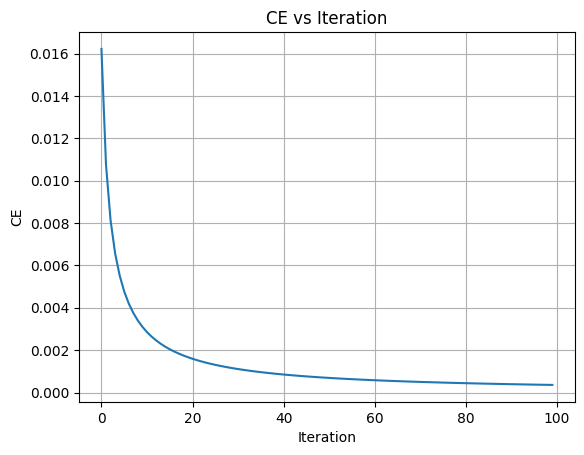

In [7]:
input = np.array([[1, 6], [2, 3], [-2, -3], [-5, -7]])
expected_output = [0, 0, 1, 1]

layer1 = Layer(2, 1, "sigmoid")
layer2 = Layer(3, 1, "sigmoid")

model = Model("cross_entropy")
model.add(layer1)
# model.add(layer2)
model.show_layers()

ce_list = []
weights = []

for i in range(100):
    model.train_one_cycle(input, expected_output, 0.5)
    mce = 0
    ce = model.cross_entropy(input, expected_output)
    ce_list.append(ce)


for i in range(len(input)):
    print(
        f"Input: {input[i]}, Expected output: {expected_output[i]}, Predicted: {model.predict(input[i])}"
    )

# print(model.layers[0].weights)

plt.plot(ce_list)
plt.xlabel("Iteration")
plt.ylabel("CE")
plt.title("CE vs Iteration")
plt.grid(True)
plt.show()


#### Regression test

Layer 1: input size: 5, output size: 1, activation: linear
[np.float64(8.9), np.float64(10.9), np.float64(16.4), np.float64(9.1), np.float64(15.5), np.float64(8.100000000000001), np.float64(17.299999999999997)]

Input: [5 8 3 2 1] Expected output: 8.90 prediction: [8.94854907]
Input: [4 2 1 5 6] Expected output: 10.90 prediction: [10.4234327]
Input: [6 1 6 8 9] Expected output: 16.40 prediction: [16.46229716]
Input: [7 4 3 2 1] Expected output: 9.10 prediction: [9.31236058]
Input: [3 6 7 8 8] Expected output: 15.50 prediction: [15.61871115]
Input: [3 5 1 3 3] Expected output: 8.10 prediction: [7.77365593]
Input: [7 5 3 9 5] Expected output: 17.30 prediction: [17.30332152]


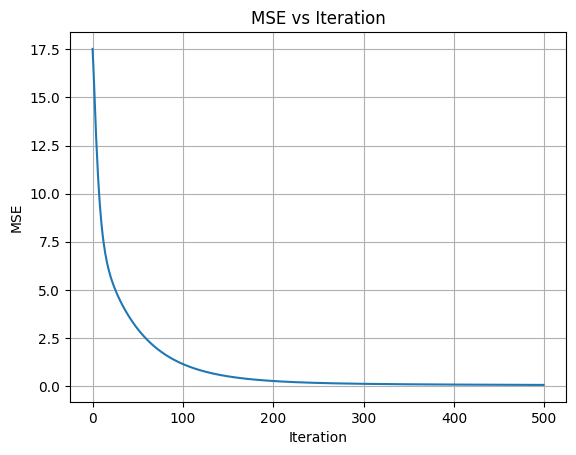

In [13]:
layer1 = Layer(5, 5, activation="sigmoid")
layer2 = Layer(5, 5, activation="linear")
layer3 = Layer(5, 1, activation="linear")


model = Model(loss_function='mse')
# model.add(layer1)
# model.add(layer2)
model.add(layer3)
model.show_layers()

input = np.array([[5, 8, 3, 2, 1], [4, 2, 1, 5, 6], [6, 1, 6, 8, 9], [7, 4, 3, 2, 1], [3, 6, 7, 8, 8], [3,5,1,3,3], [7,5,3,9,5]])
expected_output = [(sum(i*[0.7, 0.3, 0.1, 0.9, 0.4])+0.5) for i in input]
print(expected_output)
print()
mse_list = []
weights = []
for i in range(500):
    model.train_one_cycle(input, expected_output, 0.000005, batch_size=None, momentum_beta=0.9)
    mse_list.append(model.mean_squared_error(input, expected_output))

for i in range(len(input)):
    print(f"Input: {input[i]} Expected output: {expected_output[i]:.2f} prediction: {model.predict(input[i])}")

plt.plot(mse_list)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE vs Iteration')
plt.grid(True)
plt.show()

### Predicting the data
It uses two layers: (9-20), and (20-1) layer.

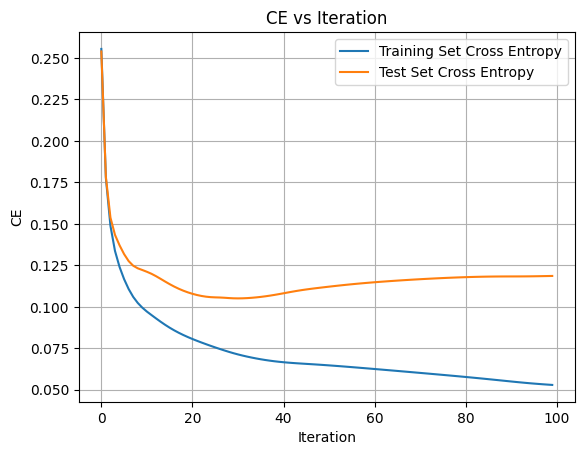


Train CM: 
--------------------------
|       pred=0 |  pred=1 |
--------------------------
| y=0 |    317 |       7 |
| y=1 |      0 |     176 |
--------------------------

Test CM: 
--------------------------
|       pred=0 |  pred=1 |
--------------------------
| y=0 |    115 |       5 |
| y=1 |      0 |      63 |
--------------------------

Training set:
******************************
Accuracy: 0.986
Balanced accuracy: 0.9891975308641976
Precision: 0.9617486338797814
Recall (Sensitivity): 1.0
Specificity: 0.9783950617283951
F1 Score: 0.9805013927576601

Test set:
******************************
Accuracy: 0.9726775956284153
Balanced accuracy: 0.9791666666666667
Precision: 0.9264705882352942
Recall (Sensitivity): 1.0
Specificity: 0.9583333333333334
F1 Score: 0.9618320610687023


In [22]:
model = Model("cross_entropy")
model.add(Layer(9, 20, "sigmoid"))
model.add(Layer(20, 1, "sigmoid"))

ce_list = []
ce_test = []

for epoch in range(100):
  model.train_one_cycle(X.values[:500], y.values[:500], learning_rate=0.5, batch_size=20)
  ce = model.cross_entropy(X.values[:500], y.values[:500])
  ce_list.append(ce)
  ce_test.append(model.cross_entropy(X.values[500:], y.values[500:]))

plt.plot(ce_list, label="Training Set Cross Entropy")
plt.plot(ce_test, label="Test Set Cross Entropy")
plt.xlabel("Iteration")
plt.ylabel("CE")
plt.title("CE vs Iteration")
plt.grid(True)
plt.legend()
plt.show()

train_cm = model.confusion_matrix(X.values[:500], y.values[:500])
test_cm = model.confusion_matrix(X.values[500:], y.values[500:]) 

print()
print("Train CM: ")
model.visualiseCM(train_cm)
print()
print("Test CM: ")
model.visualiseCM(test_cm)
print()
print(f"Training set:\n{30*'*'}")
print(f"Accuracy: {model.accuracy(train_cm)}")
print(f"Balanced accuracy: {model.balanced_accuracy(train_cm)}")
print(f"Precision: {model.precision(train_cm)}")
print(f"Recall (Sensitivity): {model.recall(train_cm)}")
print(f"Specificity: {model.specificity(train_cm)}")
print(f"F1 Score: {model.f1_score(train_cm)}")
print()
print(f"Test set:\n{30*'*'}")
print(f"Accuracy: {model.accuracy(test_cm)}")
print(f"Balanced accuracy: {model.balanced_accuracy(test_cm)}")
print(f"Precision: {model.precision(test_cm)}")
print(f"Recall (Sensitivity): {model.recall(test_cm)}")
print(f"Specificity: {model.specificity(test_cm)}")
print(f"F1 Score: {model.f1_score(test_cm)}")

#### Logistic regression

A one-layer neural network with sigmoid activation and cross-entropy loss can also be considered as a logistic regresssion. 

Although the model uses cross-entropy loss instead of negative log-likelihood loss, they are actually same. 

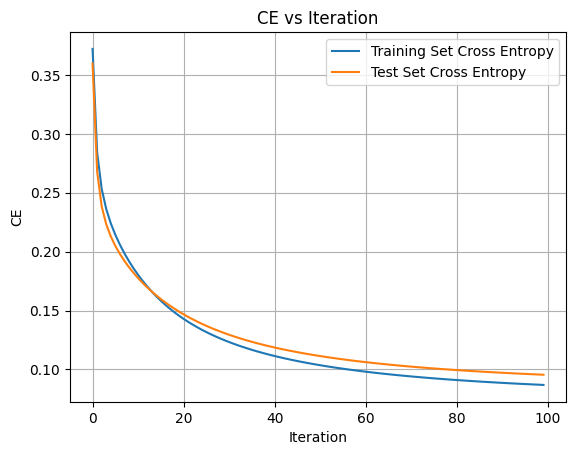


Train CM: 
--------------------------
|       pred=0 |  pred=1 |
--------------------------
| y=0 |    316 |       8 |
| y=1 |      4 |     172 |
--------------------------

Test CM: 
--------------------------
|       pred=0 |  pred=1 |
--------------------------
| y=0 |    117 |       3 |
| y=1 |      2 |      61 |
--------------------------

Training set:
******************************
Accuracy: 0.976
Balanced accuracy: 0.976290684624018
Precision: 0.9555555555555556
Recall (Sensitivity): 0.9772727272727273
Specificity: 0.9753086419753086
F1 Score: 0.9662921348314608

Test set:
******************************
Accuracy: 0.9726775956284153
Balanced accuracy: 0.9716269841269841
Precision: 0.953125
Recall (Sensitivity): 0.9682539682539683
Specificity: 0.975
F1 Score: 0.9606299212598425


In [23]:
model = Model("cross_entropy")
model.add(Layer(9, 1, "sigmoid"))

ce_list = []
ce_test = []

for epoch in range(100):
  model.train_one_cycle(X.values[:500], y.values[:500], learning_rate=0.1, batch_size=20)
  ce = model.cross_entropy(X.values[:500], y.values[:500])
  ce_list.append(ce)
  ce_test.append(model.cross_entropy(X.values[500:], y.values[500:]))

plt.plot(ce_list, label="Training Set Cross Entropy")
plt.plot(ce_test, label="Test Set Cross Entropy")
plt.xlabel("Iteration")
plt.ylabel("CE")
plt.title("CE vs Iteration")
plt.legend()
plt.grid(True)
plt.show()

train_cm = model.confusion_matrix(X.values[:500], y.values[:500])
test_cm = model.confusion_matrix(X.values[500:], y.values[500:]) 

print()
print("Train CM: ")
model.visualiseCM(train_cm)
print()
print("Test CM: ")
model.visualiseCM(test_cm)
print()
print(f"Training set:\n{30*'*'}")
print(f"Accuracy: {model.accuracy(train_cm)}")
print(f"Balanced accuracy: {model.balanced_accuracy(train_cm)}")
print(f"Precision: {model.precision(train_cm)}")
print(f"Recall (Sensitivity): {model.recall(train_cm)}")
print(f"Specificity: {model.specificity(train_cm)}")
print(f"F1 Score: {model.f1_score(train_cm)}")
print()
print(f"Test set:\n{30*'*'}")
print(f"Accuracy: {model.accuracy(test_cm)}")
print(f"Balanced accuracy: {model.balanced_accuracy(test_cm)}")
print(f"Precision: {model.precision(test_cm)}")
print(f"Recall (Sensitivity): {model.recall(test_cm)}")
print(f"Specificity: {model.specificity(test_cm)}")
print(f"F1 Score: {model.f1_score(test_cm)}")